In [1]:
# Clone our GitHub repository into the Colab environment
!git clone https://github.com/GSebs/ml-health-forecasting-transformer.git

%cd ml-health-forecasting-transformer

!pip install -r requirements.txt

Cloning into 'ml-health-forecasting-transformer'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 19 (delta 3), reused 17 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (19/19), 1.83 MiB | 26.79 MiB/s, done.
Resolving deltas: 100% (3/3), done.
/content/ml-health-forecasting-transformer
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 146.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 110.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 84.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 129.1 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


We start off by loading our processed data (which we feature engineered) and organize it in to a stream so the Transformer can process. For the engine data we will look at batches of 64 sequences (30 cycles per sequence) at a time. 

Since we are connecting to a GPU we have to convert the data to tensors. Tensors are better for parallel compute. (NumpPy arrays are stored in local system RAM which GPU don't have access to, optimal for CPUs, so we manually move it to the GPU VRAM, using .to('cuda'))

Then the inputs (x) and the corresponding outputs (y) are zipped together with 'TensorDataset', which the 'DataLoader' takes the zipped data and splits into batches of 64.

In [3]:
import torch
import numpy as np
import os
import pytorch_lightning as pl
import torch.nn as nn
import math
from torch.utils.data import TensorDataset, DataLoader
from pytorch_lightning.loggers import CSVLogger


DATA_DIR = 'data'
ARTIFACTS_DIR = os.path.join(DATA_DIR, 'artifacts') #were are processed data is saved
BATCH_SIZE = 64 

#load the preprocessed data from .npy files into computers memory
X_train = np.load(os.path.join(ARTIFACTS_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(ARTIFACTS_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(ARTIFACTS_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(ARTIFACTS_DIR, 'y_val.npy'))


train_features = torch.tensor(X_train, dtype=torch.float32)
train_targets = torch.tensor(y_train, dtype=torch.float32)
val_features = torch.tensor(X_val, dtype=torch.float32)
val_targets = torch.tensor(y_val, dtype=torch.float32)

#shuffle is true for training data loader to ensure randomness during training and forces the model to look for the degradation patterns rather than memorizing the sequence of data
train_loader = DataLoader(TensorDataset(train_features, train_targets), batch_size=BATCH_SIZE, shuffle=True)
#shuffle is false for validation data loader to maintain consistency during evaluation
val_loader = DataLoader(TensorDataset(val_features, val_targets), batch_size=BATCH_SIZE, shuffle=False)

print(f"Data Loaded. Input Dimensions: {X_train.shape}")

Data Loaded. Input Dimensions: (14184, 30, 17)


To overcome the issue of Transformer models being blind to time, we have to do positional encoding. 

The LSTM model (which was our baseline) process the data step-by-step, but the Transformer will simultaneously process an entire 30-cylce sequence. The positional encoding is to mathematically 'stamp' each cycle so Self-Attention mechanism understands the temporal distance (so the Transformer understands when degradation happenes in relation to the failure of the engine)

Esentially the Positional Encoding is to give the Transformer a perception of time flow

In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()

        #matrix to hold the positional encodings
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1) #position indices of the time steps
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        # use buffers to make sure the time stamps are fixed constant
        #we don't want them to be updated during training
        self.register_buffer('pe', pe.unsqueeze(0)) 

    def forward(self, x):

        x = x + self.pe[:, :x.size(1), :]
        return x

The Transformer architecture starts by building the model with the specifc layers we will use. We feed the initializer the input features (17) which the 'self.input_net' layer is able to take the raw physical readings and turn it in to 'Machine-Learnable Patterns/Concepts'. 

We want to convert this raw data into vectors (d_model) that can be split in to smaller vectors, so that the attension heads can look at different chunks of the input data simultaneously and therefore identify different types of pattens from that input data.

The problem with the raw data is that if we try to split the 17 features among 4 attention heads, then we get a messy number and it would be a small number of features to work with. This prevents the heads from being able to pick up the complex relationships. Kind of like trying to identify a person by looking through a peep-hole.

By using the 'self.input_net' to create these d_model's size of 64 then the heads are able to have enough mathematical bandwith to identify these complex patterns. 

This layer by using learnable weights to get the significance of features so that the Transformer is able to undersand the importance of which features. Also, the ReLU activation is able to assit the model in identifying and focus on when there are activity of faults in the signals. 

We also define our positional encoder to help the Transfomer understand time flow.

The 'self.transformer_encoder' is focusing on the ability to connect patterns from distant temporal events without having to go through the middle events. Each attention head looks for different patterns and the self.transformer_encoder combines the insights from all 4 heads to build a complete, nuanced understanding of the engine's health.

Example on how the 'self.transformer_encoder' layer works:

    Input to this layer: A sequence of 30 "Isolated Facts."

    Cycle 15: "Temp is 500." (Just a number).

    Output of this layer: A sequence of 30 "Contextual Insights."

    Cycle 15: "Temp is 500, which is dangerous because Cycle 10 was only 400."


Last the 'self.decoder' layer takes the complex, high-dimensional understanding from the Transformer and condenses it down to one single number: the RUL prediction.


In [5]:
class TransformerBaseline(pl.LightningModule):
    #input dim: number of features ; d_model: embedding dimension ; nhead: number of attention heads ; num_layers: stacks of transformer layers ontop of each other to learn deeper and more complex patterns ; dropout: dropout rate for regularization ; learning_rate
    def __init__(self, input_dim, d_model=64, nhead=4, num_layers=2, dropout=0.1, learning_rate=0.0005):
        super().__init__()
        self.save_hyperparameters()

        #input linear layer to project the input features to the model dimension (d_model)
        self.input_net = nn.Sequential(
            nn.Linear(input_dim, d_model),
            nn.ReLU()
        )

        self.pos_encoder = PositionalEncoding(d_model)


        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

 
        self.decoder = nn.Sequential(
            nn.Linear(d_model, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

        self.criterion = nn.MSELoss()

    def forward(self, x):

        
        # 1. Embed: Translate raw features to high-dim space
        x = self.input_net(x)
        # 2. Timestamp: Add time context (Cycle 1 vs Cycle 30)
        x = self.pos_encoder(x)
        
        # 3. Analyze: The Transformer looks at the whole window
        # Output Shape: [Batch, 30, 64] -> (30 rich vectors)
        x = self.transformer_encoder(x)
        
        # 4. Summarize (Global Average Pooling):
        # The Transformer outputs an understanding for EACH cycle.
        # But we need ONE prediction for the whole window.
        # We take the AVERAGE of all 30 cycles to get a "Summary Vector."
        # Output Shape: [Batch, 64]
        x = x.mean(dim=1) 
        
        # 5. Predict: Convert the summary vector to a single RUL number.
        prediction = self.decoder(x)
        return prediction

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.criterion(y_pred, y.view(-1, 1))
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.criterion(y_pred, y.view(-1, 1))
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)

Start Training 

In [6]:
csv_logger = CSVLogger("training_logs", name="transformer_baseline")

input_dim = X_train.shape[2]
model = TransformerBaseline(input_dim=input_dim)


trainer = pl.Trainer(
    max_epochs=30, 
    accelerator='gpu', 
    devices=1,
    enable_progress_bar=True,
    logger=csv_logger
)

print("Starting Transformer Training...")
trainer.fit(model, train_loader, val_loader)
print("Transformer Training Complete.")

INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
/usr/local/lib/python3.12/dist-packages/torch/__init__.py:1551: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Con

Starting Transformer Training...


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name                ┃ Type               ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ input_net           │ Sequential         │  1.2 K │ train │     0 │
│ 1 │ pos_encoder         │ PositionalEncoding │      0 │ train │     0 │
│ 2 │ transformer_encoder │ TransformerEncoder │  562 K │ train │     0 │
│ 3 │ decoder             │ Sequential         │  2.1 K │ train │     0 │
│ 4 │ criterion           │ MSELoss            │      0 │ train │     0 │
└───┴─────────────────────┴────────────────────┴────────┴───────┴───────┘

Trainable params: 565 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 565 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 31                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 
'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


Transformer Training Complete.


In [ ]:
# Plot Training and Validation Loss Curves for Transformer Model
import numpy as np
import matplotlib.pyplot as plt

# Training and validation loss data from training output
train_losses = np.array([
    0.0517, 0.0145, 0.0123, 0.0123, 0.0116, 0.0116, 0.0112, 0.0112, 0.0111, 0.0112,
    0.0110, 0.0108, 0.0107, 0.0107, 0.0106, 0.0106, 0.0106, 0.0109, 0.0102, 0.0106,
    0.0103, 0.0103, 0.0103, 0.0104, 0.0103, 0.0101, 0.0100, 0.0100, 0.0101, 0.0098
])

val_losses = np.array([
    0.0203, 0.0125, 0.0119, 0.0184, 0.0118, 0.0113, 0.0131, 0.0140, 0.0109, 0.0132,
    0.0128, 0.0168, 0.0111, 0.0125, 0.0118, 0.0164, 0.0145, 0.0119, 0.0140, 0.0112,
    0.0125, 0.0134, 0.0104, 0.0108, 0.0110, 0.0144, 0.0115, 0.0115, 0.0130, 0.0147
])

epochs = np.arange(1, len(train_losses) + 1)

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_losses, 
         label='Training Loss', linewidth=2, marker='o', markersize=4)
plt.plot(epochs, val_losses, 
         label='Validation Loss', linewidth=2, marker='s', markersize=4, linestyle='--')

plt.title('Transformer Model: Training and Validation Loss Curves', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MSE Loss (Lower is Better)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print final metrics
print(f"\nFinal Training Loss: {train_losses[-1]:.4f}")
print(f"Final Validation Loss: {val_losses[-1]:.4f}")
print(f"Best Validation Loss: {val_losses.min():.4f} (Epoch {np.argmin(val_losses) + 1})")
print(f"Best Training Loss: {train_losses.min():.4f} (Epoch {np.argmin(train_losses) + 1})")


FileNotFoundError: [Errno 2] No such file or directory: 'training_logs/transformer_baseline/version_0/metrics.csv'

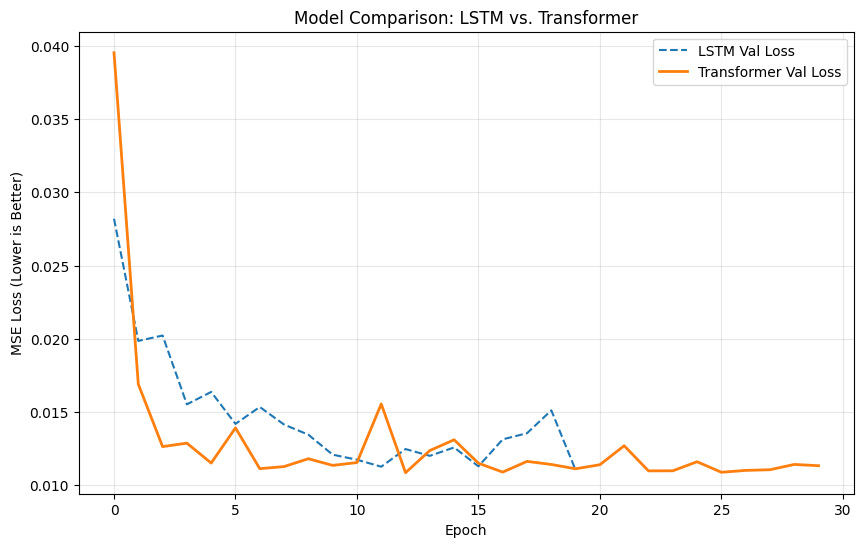

In [9]:
import pandas as pd
import matplotlib.pyplot as plt


lstm_path = 'training_logs/lstm_baseline/version_0/metrics.csv' 
lstm_df = pd.read_csv(lstm_path).groupby('epoch').mean()


trans_path = 'training_logs/transformer_baseline/version_0/metrics.csv'
trans_df = pd.read_csv(trans_path).groupby('epoch').mean()

plt.figure(figsize=(10, 6))
plt.plot(lstm_df['val_loss'], label='LSTM Val Loss', linestyle='--')
plt.plot(trans_df['val_loss'], label='Transformer Val Loss', linewidth=2)
plt.title('Model Comparison: LSTM vs. Transformer')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss (Lower is Better)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()